<a href="https://colab.research.google.com/github/BMugo84/pytorch_in_25_hours/blob/main/08_pytorch_paper_replicating_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exercises

> **Note:** These exercises expect the use of `torchvision` v0.13+ (released July 2022), previous versions may work but will likely have errors.

All of the exercises are focused on practicing the code above.

You should be able to complete them by referencing each section or by following the resource(s) linked.

All exercises should be completed using [device-agnostic code](https://pytorch.org/docs/stable/notes/cuda.html#device-agnostic-code).

**Resources:**

* [Exercise template notebook for 08](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/08_pytorch_paper_replicating_exercises.ipynb).
* [Example solutions notebook for 08](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/08_pytorch_paper_replicating_exercise_solutions.ipynb) (try the exercises *before* looking at this).
    * See a live [video walkthrough of the solutions on YouTube](https://youtu.be/tjpW_BY8y3g) (errors and all).

# import/dataloaders

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056 (from 1)
Receiving objects: 100% (4056/4056), 646.90 MiB | 33.03 MiB/s, done.
Resolving deltas: 100% (2372/2372), done.
Updating files: 100% (248/248), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [4]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [5]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [6]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a294d7ccbb0>,
 ['pizza', 'steak', 'sushi'])

In [7]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

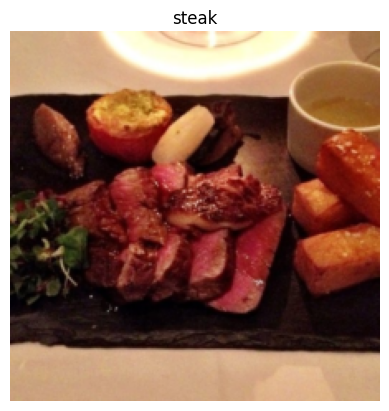

In [8]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

# 1. Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).


* You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks).
* You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).


## from equation to code

### Patchifier

In [9]:
# patchify images using conv2d
patch_size = 16
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

image_convd = conv2d(image.unsqueeze(0))
image_convd.shape

torch.Size([1, 768, 14, 14])

showing the conv feature maps from indexes: range(0, 14)


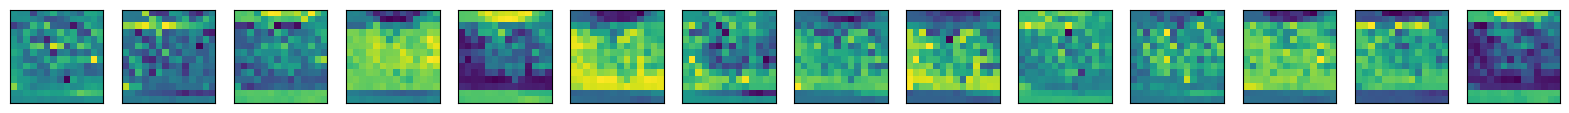

In [10]:
# view image_convd. well atleast the first row
fig, axs = plt.subplots(nrows=1, ncols=14, figsize=(20,20))

print(f"showing the conv feature maps from indexes: {range(0,14)}")
for i, idx in enumerate(range(0,14)):
    image_conv_feature_map = image_convd[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [11]:
# flatten the convd image into 1x1 of [batch, embedding_dims, height, width]
flatten = nn.Flatten(start_dim=2,# flatten height
                     end_dim=3)# flatten width

image_convd_flattened = flatten(image_convd)
image_convd_flattened.shape

torch.Size([1, 768, 196])

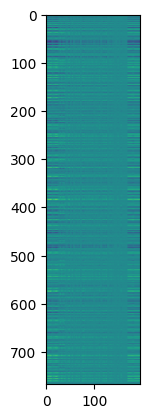

In [12]:
plt.imshow(image_convd_flattened.squeeze().detach().numpy())


torch.Size([1, 196, 768])

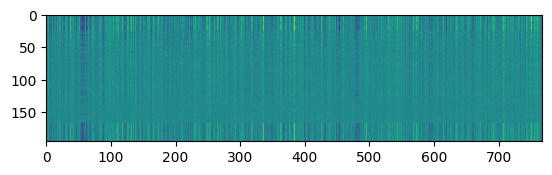

In [13]:
# permutte to change it from [batch, embedded_dim, number_of_patches] to [batch, num_patches, embedded_dim]
image_convd_flattened_reshaped = image_convd_flattened.permute(0, 2, 1)
plt.imshow(image_convd_flattened_reshaped.squeeze().detach().numpy())
image_convd_flattened_reshaped.shape

In [14]:
# add extra learnable class token
# get the batch size and embedding dim
batch_size = image_convd_flattened_reshaped.shape[0]
embedding_dim = image_convd_flattened_reshaped.shape[-1]

# create class token embedding as a learnable parameter
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dim),
                           requires_grad=True)

print(f"Patched image shape before adding class token: {image_convd_flattened_reshaped.shape}")
print(f"Class token shape: {class_token.shape}")

# prepend class token
patched_image_with_class_embedding = torch.cat((class_token, image_convd_flattened_reshaped),
                                               dim=1)

print(f"Patched image shape after adding class token: {patched_image_with_class_embedding.shape}")

Patched image shape before adding class token: torch.Size([1, 196, 768])
Class token shape: torch.Size([1, 1, 768])
Patched image shape after adding class token: torch.Size([1, 197, 768])


In [15]:
height, width = image.shape[-2], image.shape[-1]
(height*width) / patch_size**2

196.0

In [16]:
# adding positional embeddings
batch_size = patched_image_with_class_embedding.shape[0]
embedding_dim = patched_image_with_class_embedding.shape[-1]
height, width = image.shape[-2], image.shape[-1]
num_patches = int((height*width) / patch_size**2)

# create positional embedding as a learnable parameter
position_embeddings = nn.Parameter(torch.randn(batch_size, num_patches+1, embedding_dim),
                           requires_grad=True)

patch_plus_position_embedding = patched_image_with_class_embedding + position_embeddings
patch_plus_position_embedding.shape

torch.Size([1, 197, 768])

In [17]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patch_size = patch_size

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [28]:
rand_image_tensor = torch.randn(32, 3, 224, 224) # (batch_size, color_channels, height, width)
# rand_image_tensor.shape
patch_embedding = PatchEmbedding(patch_size=16)
image_patchified = patch_embedding(rand_image_tensor)
print(f"Input shape: {rand_image_tensor.shape}")
print(f"Output shape: {image_patchified.shape} -> (batch_size, num_patches, embedding_dim)")

Input shape: torch.Size([32, 3, 224, 224])
Output shape: torch.Size([32, 196, 768]) -> (batch_size, num_patches, embedding_dim)


### scaled dot product attention
$$
\mathbf{z}_{\ell}^{\prime} = \operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right) + \mathbf{z}_{\ell-1}, \quad \ell = 1 \dots L
$$



<img src="https://www.researchgate.net/publication/333078019/figure/fig1/AS:758304078839808@1557805189409/left-Scaled-Dot-Product-Attention-right-Multi-Head-Attention.png" width=900/>


#### Pseudocode for Scaled Dot-Product Attention:
1. **Multiply**: Compute the dot product between the query (\(\mathbf{Q}\)) and key (\(\mathbf{K}\)) matrices.
2. **Scale**: Divide the resulting dot product by the square root of the dimension of the key vectors (\(\sqrt{D_k}\)) to obtain the scaled dot-product.
3. **Apply Masking** (if needed): Add a mask to the scaled dot-product to prevent attention to certain positions (e.g., for padding or future tokens in the case of autoregressive models).
4. **Apply Softmax**: Apply the softmax function to the masked and scaled dot-product matrix to obtain attention weights.
5. **Dot Product with \(\mathbf{V}\)**: Multiply the attention weights by the value (\(\mathbf{V}\)) matrix to get the final output.



In [29]:
# initialize patchified image
q = k = v = image_patchified

In [21]:
q.shape, k.shape, k.T.shape

<ipython-input-21-15690a14ba2f>:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  q.shape, k.shape, k.T.shape


(torch.Size([32, 196, 768]),
 torch.Size([32, 196, 768]),
 torch.Size([768, 196, 32]))

In [30]:


# initialize patchified image
q = k = v = image_patchified # Shape: [batch_size, num_patches, embedded_dim]

# Step 1: Multiply - Calculate the dot product of the query and key matrices using matmul
qk_matmul = torch.matmul(q, k.transpose(-2, -1))  # Shape: [batch_size, num_patches, num_patches]

# Step 2: Scale - Divide the result by the square root of the key's dimension
embedded_dim = k.shape[-1]
qk_scaled = qk_matmul / torch.sqrt(torch.tensor(embedded_dim, dtype=torch.float32))

# Step 3: (Optional) Mask - Add a mask to ignore certain positions (usually in transformers)

# Step 4: Softmax - Apply the softmax function to turn the scaled dot-product into probabilities
softmax = nn.Softmax(dim=-1)
qk_softmaxed = softmax(qk_scaled)  # Shape: [batch_size, num_patches, num_patches]

# Step 5: Multiply with V - Use these probabilities to weigh the values matrix, giving the final output
attn_qkv = torch.matmul(qk_softmaxed, v)  # Shape: [batch_size, num_patches, embedded_dim]

attn_qkv  # This is the final attention output


tensor([[[-0.3774, -0.3064,  0.5251,  ..., -0.1158,  0.6743, -0.2830],
         [ 0.3173, -1.0147, -0.7914,  ..., -0.0082, -0.8646, -0.0702],
         [ 0.0262,  1.0640,  0.1906,  ...,  0.0265, -0.8015, -0.1396],
         ...,
         [ 0.2945, -0.0018,  0.3586,  ...,  0.4002,  0.1789,  0.9695],
         [ 0.5384, -0.2015, -1.2195,  ..., -0.2694,  0.3279,  0.2502],
         [-0.4042, -1.2628,  0.0762,  ..., -0.0456, -0.6342,  0.3102]],

        [[-0.7366,  0.3685,  0.2422,  ..., -0.5395,  0.3816, -0.5570],
         [ 0.7766, -0.3923, -0.3846,  ...,  1.0926,  1.0997,  0.5105],
         [ 0.2269, -0.0189,  0.3402,  ...,  0.0159,  0.1338, -0.4000],
         ...,
         [ 0.9293, -0.2468, -0.7087,  ...,  0.5746, -1.3298, -0.3032],
         [ 0.3124, -0.0882,  0.1258,  ..., -1.2660,  0.2349, -0.1546],
         [-0.5093, -0.5061,  0.1572,  ...,  0.0641,  0.6710,  0.8009]],

        [[-0.6258, -0.3991, -1.0041,  ..., -0.2697,  0.4880,  0.4994],
         [-0.4305, -0.9947,  0.2608,  ...,  0

In [31]:
import torch
import torch.nn as nn

class ScaledDotProductAttn(nn.Module):
    def __init__(self, embedding_dim: int = 768):
        super(ScaledDotProductAttn, self).__init__()
        self.embedding_dim = embedding_dim
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        q=k=v = x
        # Matmul between query and transposed key
        qk_matmul = torch.matmul(q, k.transpose(-2, -1))

        # Scale the dot product by the square root of the embedding dimension
        qk_scaled = qk_matmul / torch.sqrt(torch.tensor(self.embedding_dim, dtype=torch.float32))

        # Apply softmax to get attention weights
        qk_softmaxed = self.softmax(qk_scaled)

        # Matmul with value
        attn_output = torch.matmul(qk_softmaxed, v)

        return attn_output



In [32]:
scaled_dot_product_attn = ScaledDotProductAttn()

#### Multihead self attention
$$
MSA(z) = [SA_1(z); SA_2(z); \dots; SA_k(z)] U_{msa}, \quad U_{msa} \in \mathbb{R}^{k \cdot D_h \times D}.
$$

In [33]:
# initiallize num_heads
num_heads = 12
# init storage for tensors
self_attn_tensors = []

for i in range(num_heads):
    attn_qkv = scaled_dot_product_attn(image_patchified)
    self_attn_tensors.append(attn_qkv)

sa_concated = torch.concat(self_attn_tensors, dim=-1)
# sa_concated.shape

u_msa = nn.Linear(in_features=sa_concated.shape[-1],
                    out_features=embedding_dim)

msa = u_msa(sa_concated)
msa.shape

torch.Size([32, 196, 768])

In [34]:
# from code to class

class MSA(nn.Module):
    def __init__(self, embedding_dim:int=768, num_heads:int=12):
        super().__init__()
        self.num_heads = num_heads
        self.scaled_dot_product_attn = ScaledDotProductAttn(embedding_dim=embedding_dim)
        self.u_msa = nn.Linear(in_features=embedding_dim*num_heads, out_features=embedding_dim)

    def forward(self, x):
        x = [self.scaled_dot_product_attn(x) for _ in range(self.num_heads)]
        x = torch.concat(x, dim=-1)
        x = self.u_msa(x)
        return x

## compiling the VIT architecture

In [35]:
# Hyperparameters from Table 1 and Table 3 for ViT-Base
transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                       nhead=12,
                                                       dim_feedforward=3072,
                                                       dropout=0.1,
                                                       activation="gelu",
                                                       batch_first=True,
                                                       norm_first=True)
transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [36]:
transformer_encoder = nn.TransformerEncoder(
    encoder_layer=transformer_encoder_layer,
    num_layers=12)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [37]:
summary(model=transformer_encoder,
        input_size=image_patchified.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoder                       [32, 196, 768]            --
├─ModuleList: 1-1                        --                        --
│    └─TransformerEncoderLayer: 2-1      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-2      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-3      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-4      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-5      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-6      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-7      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-8      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-9      [32, 196, 768]            7,087,872
│    └─TransformerEncoderLayer: 2-10     [32, 196, 768]            7,087,872
│    └─Transfor

In [38]:
class ViT(nn.Module):
  def __init__(self,
               img_size=224, # from Table 3
               num_channels=3,
               patch_size=16,
               embedding_dim=768, # from Table 1
               dropout=0.1,
               mlp_size=3072, # from Table 1
               num_transformer_layers=12, # from Table 1
               num_heads=12, # from Table 1 (number of multi-head self attention heads)
               num_classes=1000): # generic number of classes (this can be adjusted)
    super().__init__()

    # Assert image size is divisible by patch size
    assert img_size % patch_size == 0, "Image size must be divisble by patch size."

    # 1. Create patch embedding
    self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # 2. Create class token
    self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                    requires_grad=True)

    # 3. Create positional embedding
    num_patches = (img_size * img_size) // patch_size**2 # N = HW/P^2
    self.positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))

    # 4. Create patch + position embedding dropout
    self.embedding_dropout = nn.Dropout(p=dropout)

    # # 5. Create Transformer Encoder layer (single)
    # self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
    #                                                             nhead=num_heads,
    #                                                             dim_feedforward=mlp_size,
    #                                                             activation="gelu",
    #                                                             batch_first=True,
    #                                                             norm_first=True)

    # 5. Create stack Transformer Encoder layers (stacked single layers)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                              nhead=num_heads,
                                                                                              dim_feedforward=mlp_size,
                                                                                              activation="gelu",
                                                                                              batch_first=True,
                                                                                              norm_first=True), # Create a single Transformer Encoder Layer
                                                     num_layers=num_transformer_layers) # Stack it N times

    # 7. Create MLP head
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Get some dimensions from x
    batch_size = x.shape[0]

    # Create the patch embedding
    x = self.patch_embedding(x)
    # print(x.shape)

    # First, expand the class token across the batch size
    class_token = self.class_token.expand(batch_size, -1, -1) # "-1" means infer the dimension

    # Prepend the class token to the patch embedding
    x = torch.cat((class_token, x), dim=1)
    # print(x.shape)

    # Add the positional embedding to patch embedding with class token
    x = self.positional_embedding + x
    # print(x.shape)

    # Dropout on patch + positional embedding
    x = self.embedding_dropout(x)

    # Pass embedding through Transformer Encoder stack
    x = self.transformer_encoder(x)

    # Pass 0th index of x through MLP head
    x = self.mlp_head(x[:, 0])

    return x

In [39]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[ 0.0009, -0.0732,  0.2058]], grad_fn=<AddmmBackward0>)

# 2. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`.


* You should be able to import an entire ViT model using something like`from vit import ViT`.


In [40]:
%%writefile vit.py
import torch
from torch import nn

# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patch_size = patch_size

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

class ViT(nn.Module):
  def __init__(self,
               img_size=224, # from Table 3
               num_channels=3,
               patch_size=16,
               embedding_dim=768, # from Table 1
               dropout=0.1,
               mlp_size=3072, # from Table 1
               num_transformer_layers=12, # from Table 1
               num_heads=12, # from Table 1 (number of multi-head self attention heads)
               num_classes=1000): # generic number of classes (this can be adjusted)
    super().__init__()

    # Assert image size is divisible by patch size
    assert img_size % patch_size == 0, "Image size must be divisble by patch size."

    # 1. Create patch embedding
    self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # 2. Create class token
    self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                    requires_grad=True)

    # 3. Create positional embedding
    num_patches = (img_size * img_size) // patch_size**2 # N = HW/P^2
    self.positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))

    # 4. Create patch + position embedding dropout
    self.embedding_dropout = nn.Dropout(p=dropout)

    # # 5. Create Transformer Encoder layer (single)
    # self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
    #                                                             nhead=num_heads,
    #                                                             dim_feedforward=mlp_size,
    #                                                             activation="gelu",
    #                                                             batch_first=True,
    #                                                             norm_first=True)

    # 5. Create stack Transformer Encoder layers (stacked single layers)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                              nhead=num_heads,
                                                                                              dim_feedforward=mlp_size,
                                                                                              activation="gelu",
                                                                                              batch_first=True,
                                                                                              norm_first=True), # Create a single Transformer Encoder Layer
                                                     num_layers=num_transformer_layers) # Stack it N times

    # 7. Create MLP head
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Get some dimensions from x
    batch_size = x.shape[0]

    # Create the patch embedding
    x = self.patch_embedding(x)
    # print(x.shape)

    # First, expand the class token across the batch size
    class_token = self.class_token.expand(batch_size, -1, -1) # "-1" means infer the dimension

    # Prepend the class token to the patch embedding
    x = torch.cat((class_token, x), dim=1)
    # print(x.shape)

    # Add the positional embedding to patch embedding with class token
    x = self.positional_embedding + x
    # print(x.shape)

    # Dropout on patch + positional embedding
    x = self.embedding_dropout(x)

    # Pass embedding through Transformer Encoder stack
    x = self.transformer_encoder(x)

    # Pass 0th index of x through MLP head
    x = self.mlp_head(x[:, 0])

    return x

Writing vit.py


In [41]:
!python vit.py


In [42]:
import vit

In [43]:

from vit import *

x = image.unsqueeze(0)
# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit_scratch = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit_scratch(x)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


tensor([[ 0.1539,  0.0158, -0.5638]], grad_fn=<AddmmBackward0>)

In [44]:
# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit_scratch,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                          [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                 [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                            [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                           [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                      [1, 197, 768]        [1, 197, 768]        --                   --
├─TransformerEncoder (transformer_encoder)         [1, 197, 768]        [1, 197, 768]        --                   True
│    └─ModuleList (layers)                         --                   --                   --                   True
│    │    └─TransformerEncoderLayer (0)        

# 3. Train a pretrained ViT feature extractor model

(like the one we made in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset)) on 20% of the pizza, steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets).
* See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size).


In [45]:
# Create ViT feature extractor model
import torchvision

# Download pretrained ViT weights and model
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" means best available
pretrained_vit = torchvision.models.vit_b_16(weights=vit_weights)

# Freeze all layers in pretrained ViT model
for param in pretrained_vit.parameters():
  param.requires_grad = False

# Update the preatrained ViT head
embedding_dim = 768 # ViT_Base
set_seeds()
pretrained_vit.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=embedding_dim),
    nn.Linear(in_features=embedding_dim,
              out_features=len(class_names))
)

# Print a summary
summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 65.2MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [46]:
# Get 20% of the data
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

# Setup train and test directories
train_dir_20_percent = data_20_percent_path / "train"
# test_dir_20_percent = data_20_percent_path / "test" # don't need 20% test data as the model in 07. PyTorch Experiment Tracking section 7.3 tests on the 10% dataset not the 20%

# Preprocess the data
vit_transforms = vit_weights.transforms() # get transforms from vit_weights
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                           test_dir=test_dir, # use 10% data for testing
                                                                                           transform=vit_transforms,
                                                                                           batch_size=32)

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [ ]:
# Train a pretrained ViT feature extractor
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_20_percent,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

# 4. Try repeating the steps from excercise 3 but this time use the "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights

from [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16).
* **Note:** ViT pretrained with SWAG weights has a minimum input image size of `(384, 384)` (the pretrained ViT in exercise 3 has a minimum input size of `(224, 224)`), though this is accessible in the weights `.transforms()` method.


# 5. Research some of the following topics from Table 3

 in the ViT paper that we miss and write a sentence about each and how it might help with training:
* ImageNet-21k pretraining (more data).
* Learning rate warmup.
* Learning rate decay.
* Gradient clipping.